
### Goal
Test the perfomance of the following time series models as the baseline model for short-term prediction:
- [Holt-Winters (Triple Exponential Smoothing)](https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)
- [ARIMA](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA)



### Data processing __(following Roberto's code)__


In [68]:
import pandas, numpy, matplotlib, seaborn, sklearn, statsmodels, prophet
print("All packages imported successfully!")

All packages imported successfully!


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

We load the data from `data/arxiv-totals.parquet` and set up our training data set from 01/01/2001 (Monday) to 03/14/2025 (Monday), and testing data set to 03/17/2025 (Monday).

In [70]:
df = pd.read_parquet("../data/arxiv-totals.parquet")

df_train = df[
    (df.index >= pd.Timestamp(2001, 1, 1)) & (df.index <= pd.Timestamp(2025, 3, 14))
]
df_test = df[df.index >= pd.Timestamp(2025, 3, 17)]

In [71]:
print(df.columns)
print(df_train.shape, df_test.shape)
print(df.head())

Index(['hep-th', 'physics.pop-ph', 'math.LO', 'math.FA', 'math.MG', 'cs.CC',
       'math.CO', 'math.PR', 'math.DS', 'cs.GR',
       ...
       'econ.EM', 'stat.CO', 'stat.OT', 'q-fin.EC', 'eess.SY', 'econ.GN',
       'eess.AS', 'eess.IV', 'eess.SP', 'q-fin.MF'],
      dtype='object', length=158)
(6315, 158) (20, 158)
            hep-th  physics.pop-ph  math.LO  math.FA  math.MG  cs.CC  math.CO  \
date                                                                            
1986-04-28     1.0             1.0      0.0      0.0      0.0    0.0      0.0   
1988-11-14     1.0             0.0      0.0      0.0      0.0    0.0      0.0   
1989-04-17     0.0             0.0      1.0      0.0      0.0    0.0      0.0   
1989-10-27     0.0             0.0      0.0      3.0      3.0    0.0      0.0   
1989-11-10     0.0             0.0      0.0      1.0      1.0    0.0      0.0   

            math.PR  math.DS  cs.GR  ...  econ.EM  stat.CO  stat.OT  q-fin.EC  \
date                           

To get a sense of how these look like, we plot the submissions from the `hep` (High Energy Physics) category.

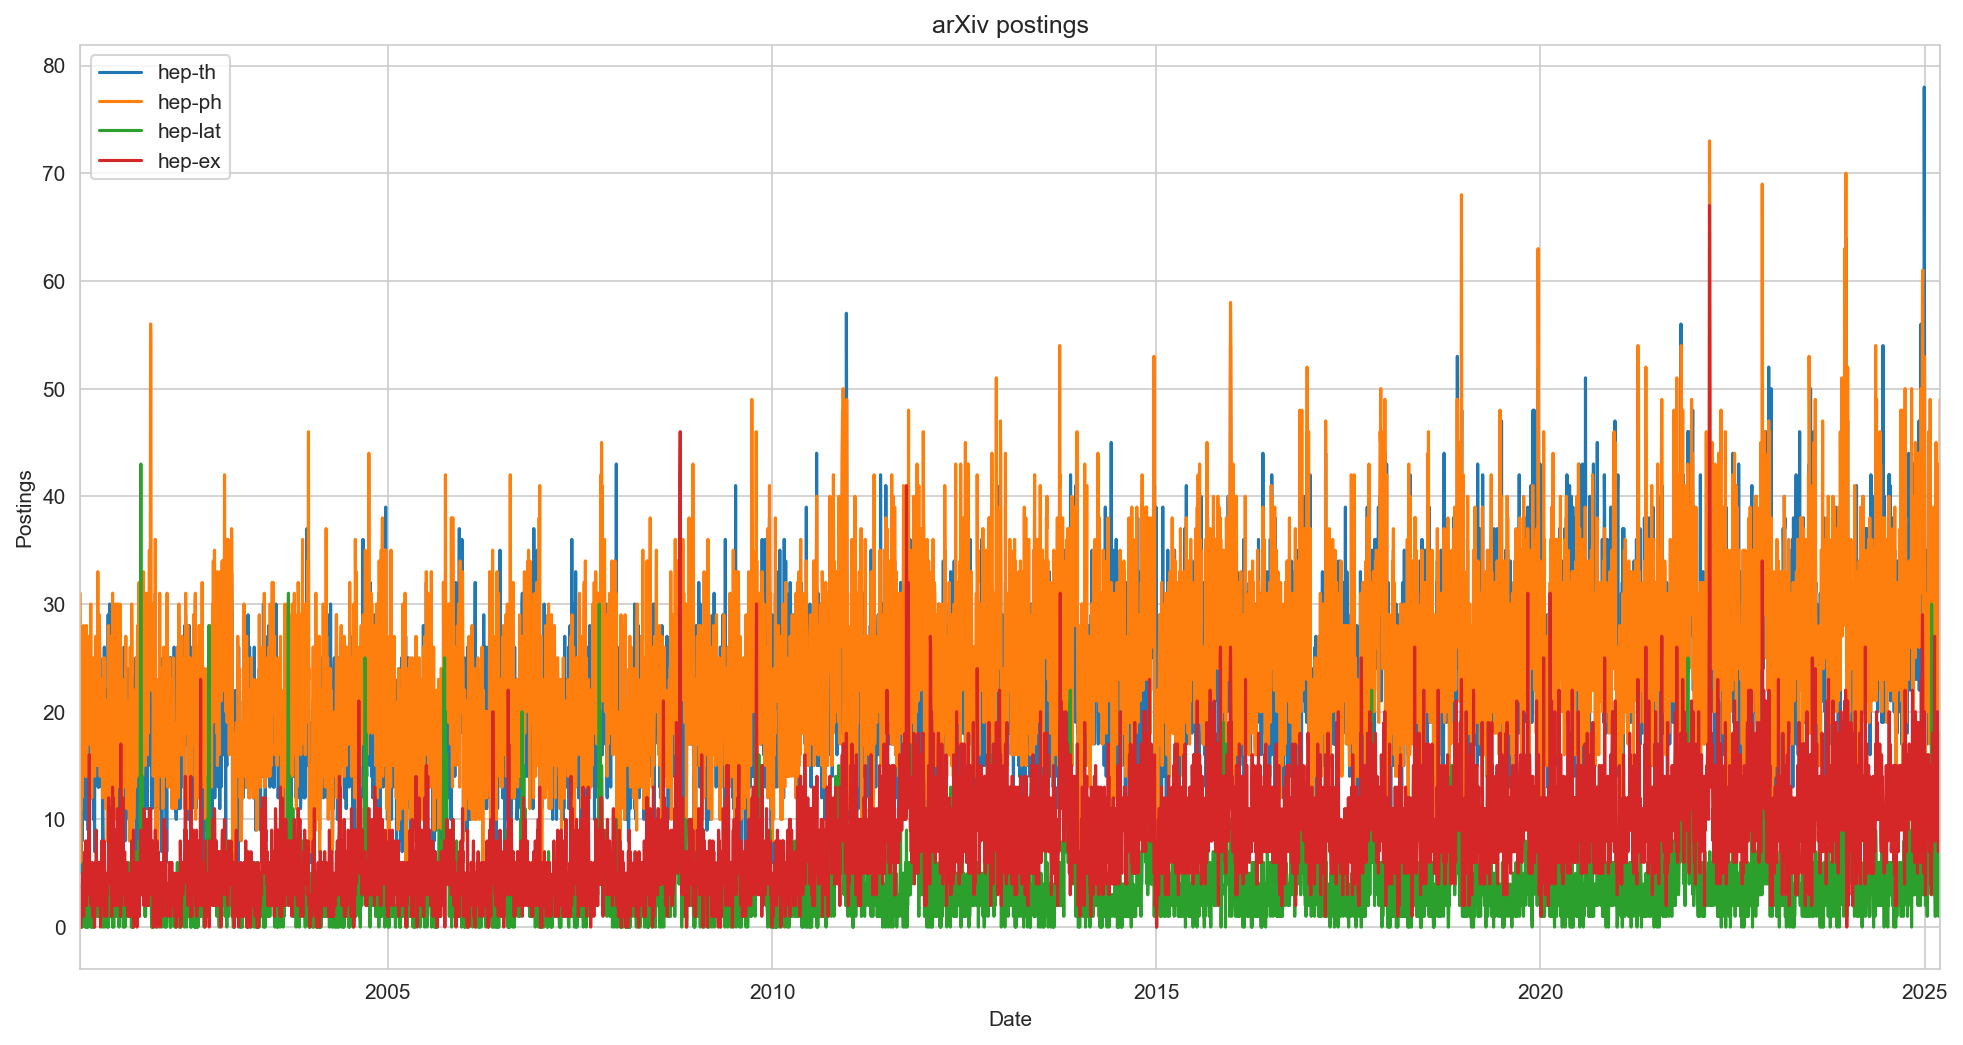

In [72]:
import matplotlib.pyplot as plt

# set plot size
plt.figure(figsize=(16, 8), dpi=150)

# adding the plots
for label, content in df_train.items():
    if label.startswith("hep-"):  # type: ignore
        content.plot(label=label)

# adding title to the plot
plt.title("arXiv postings")

# adding labels
plt.xlabel("Date")
plt.ylabel("Postings")

# adding legend to the curve
plt.legend()

We also plot `hep-ph` ("High Energy Physics - Phenomenology") by itself.

Text(0, 0.5, 'Postings')

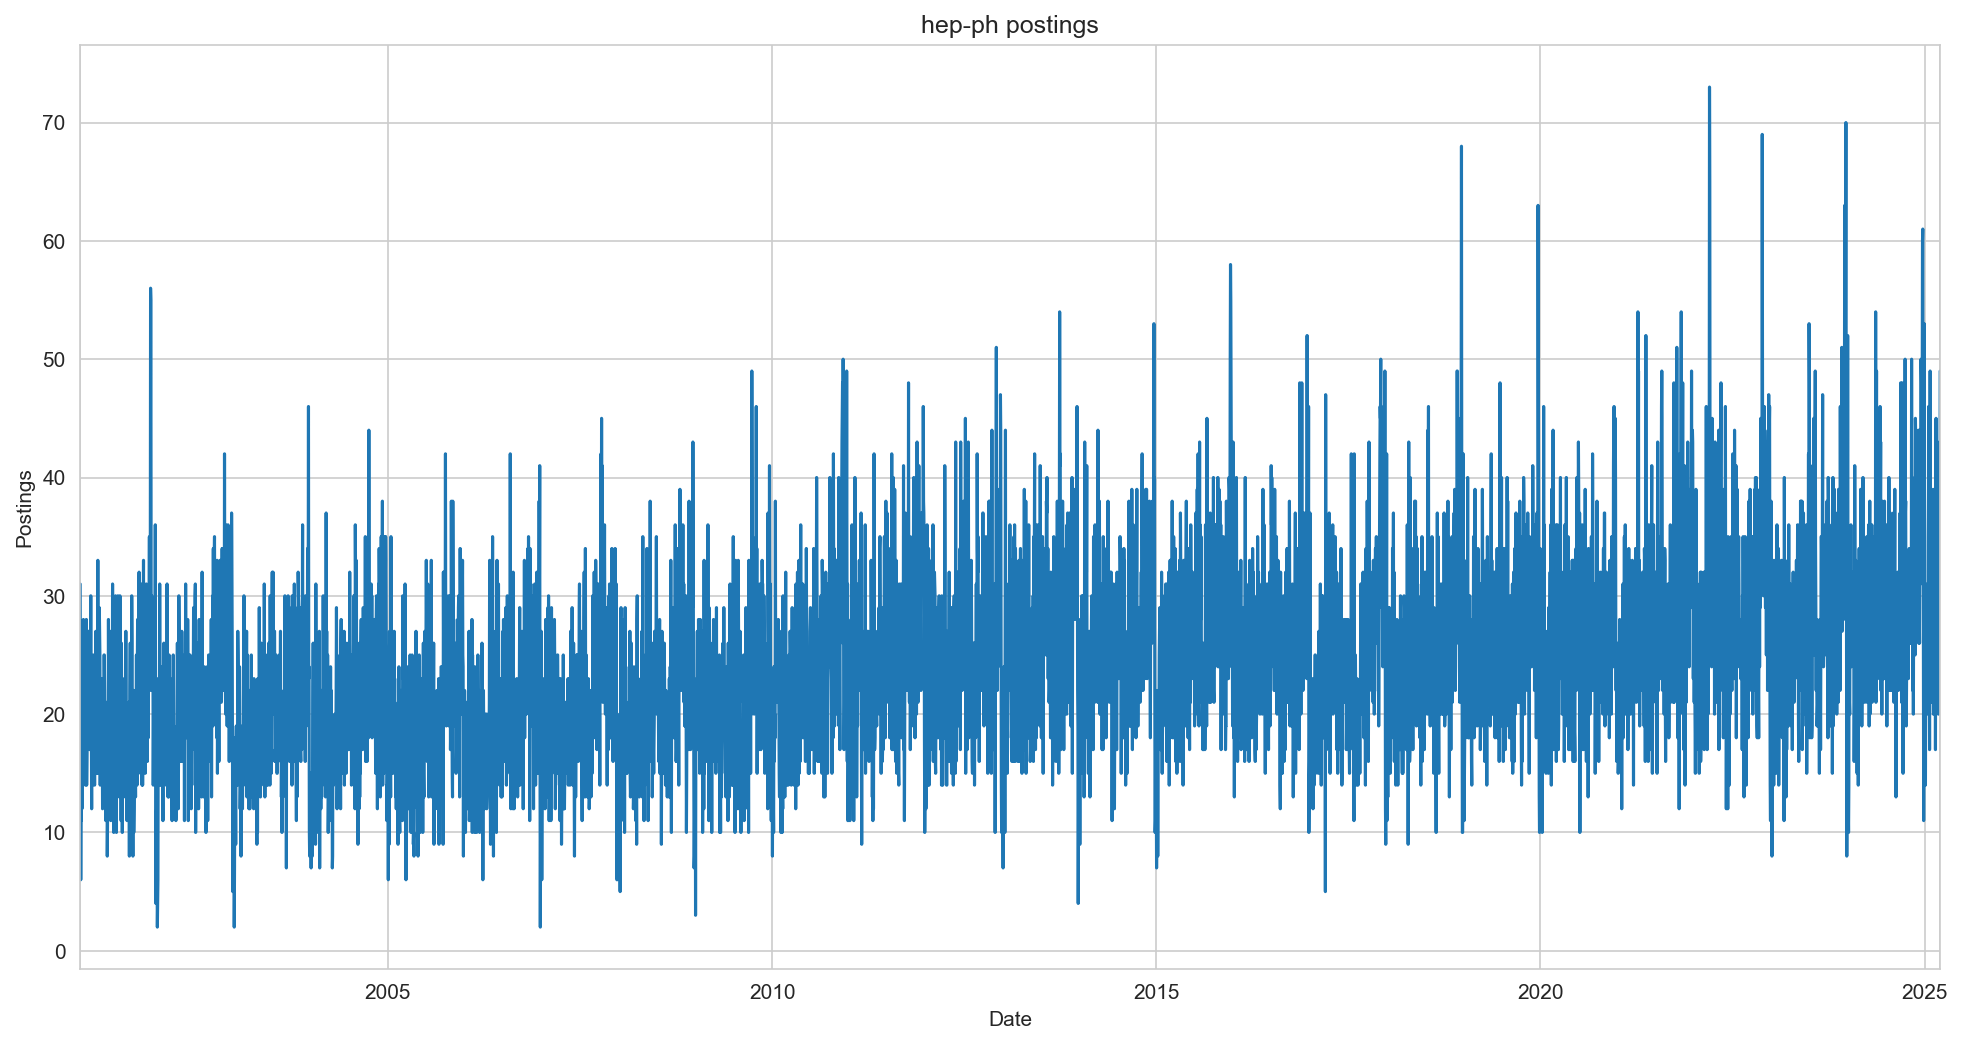

In [73]:
plt.figure(figsize=(16, 8), dpi=150)

df_train["hep-ph"].plot()

plt.title("hep-ph postings")
plt.xlabel("Date")
plt.ylabel("Postings")

We plot autocorrelation and partial autocorrelation for this last time series.

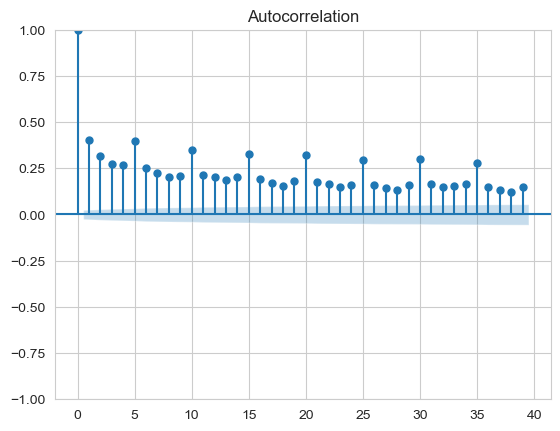

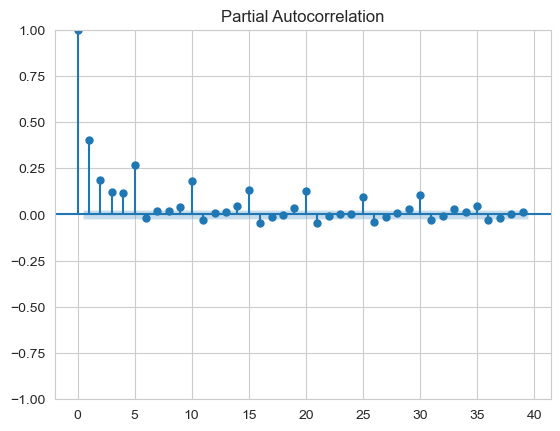

In [74]:
import statsmodels.api as sm

# Set the index to be a business day frequency
df_train = df_train.asfreq("B")

_ = sm.graphics.tsa.plot_acf(df_train["hep-ph"])
_ = sm.graphics.tsa.plot_pacf(df_train["hep-ph"])

# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(
#     df_train["hep-ph"],
#     order=(1, 0, 0),
#     seasonal_order=(1, 0, 0, 12),
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )
# results = model.fit(disp=False)
# print(results.summary())
# pred = results.get_prediction(
#     start=pd.Timestamp(2025, 3, 17), dynamic=False
# )


This indicates that the time series has seasonality, with season of a week. Other categories exhibit similar correlograms, so effective models should likely take weekly seasonality into account. Looking at the graphs, there is also a global trend to take into account.

### Set-up

We will use [statsmodels](https://www.statsmodels.org/stable/index.html) as our choice of time series library (Install the module `statsmodels` by using Anaconda `conda install -c conda-forge statsmodels`). In partucular, see [Time Series analysis `tsa`](https://www.statsmodels.org/devel/tsa.html).

In [75]:
## Importing statsmodels to check that we have it installed
import statsmodels as sm

In [76]:
## printing the statsmodels version
print(sm.__version__)

0.14.4


### Holt-Winters

In [77]:
from statsmodels.tsa.api import ExponentialSmoothing

#### Additive version

In [78]:
## Call ExponentialSmoothing
## input the training data
## set seasonal = "mul", for additive you would set it equal to "add"
## You set m using seasonal_periods = 
## Then call fit
## set a smoothing_level, alpha
## set a smoothing_trend, beta
## set a smoothing_seasonal, gamma
## Set optimized = False, unless you want maximum likelihood to estimate alpha, beta, gamma
holt_winter = ExponentialSmoothing(
    df_train["hep-ph"],  # Use a single time series column
    trend='add',         # Additive trend
    # seasonal='add',      # Additive seasonality
    seasonal_periods=52
).fit(
    smoothing_level=0.1,
    smoothing_trend=0.1,
    smoothing_seasonal=0.8,
    optimized=False
)

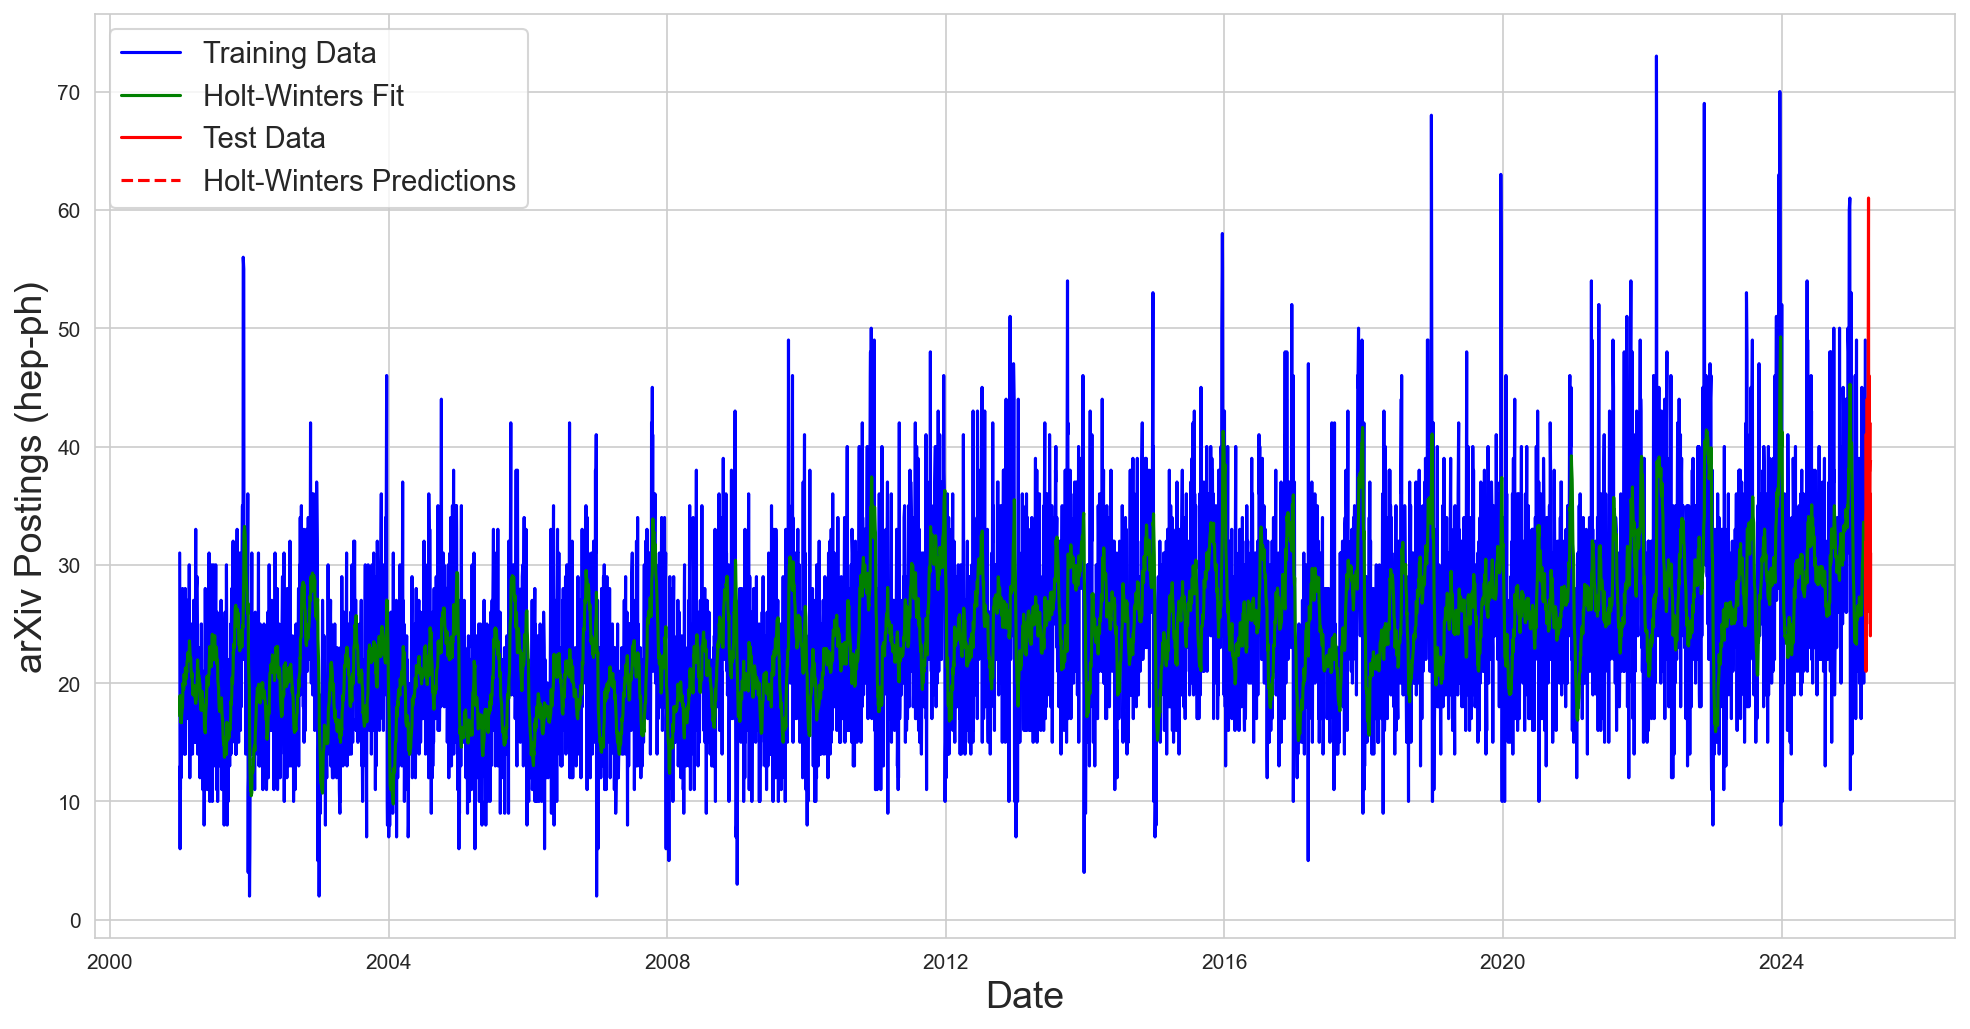

In [79]:
plt.figure(figsize=(16, 8), dpi=150)

plt.plot(df_train.index, 
         df_train["hep-ph"],
         'b-',
         label="Training Data")
plt.plot(df_train.index, 
         holt_winter.fittedvalues, 
         'g-',
         label="Holt-Winters Fit")

plt.plot(df_test.index, 
         df_test["hep-ph"],
         'r-',
         label="Test Data")

plt.plot(df_test.index, 
         holt_winter.forecast(len(df_test)),
         'r--',
         label="Holt-Winters Predictions")

plt.xlabel("Date", fontsize=18)
plt.ylabel("arXiv Postings (hep-ph)", fontsize=18)
plt.legend(fontsize=14)
plt.show()

#### Multiplicative version

In [80]:
## Call ExponentialSmoothing
## input the training data
## set seasonal = "mul", for additive you would set it equal to "add"
## You set m using seasonal_periods = 
## Then call fit
## set a smoothing_level, alpha
## set a smoothing_trend, beta
## set a smoothing_seasonal, gamma
## Set optimized = False, unless you want maximum likelihood to estimate alpha, beta, gamma
holt_winter = ExponentialSmoothing(
    df_train["hep-ph"],  # Use a single time series column
    seasonal='mul',
    seasonal_periods=52
).fit(
    smoothing_level=0.1,
    smoothing_trend=0.1,
    smoothing_seasonal=0.8,
    optimized=False
)

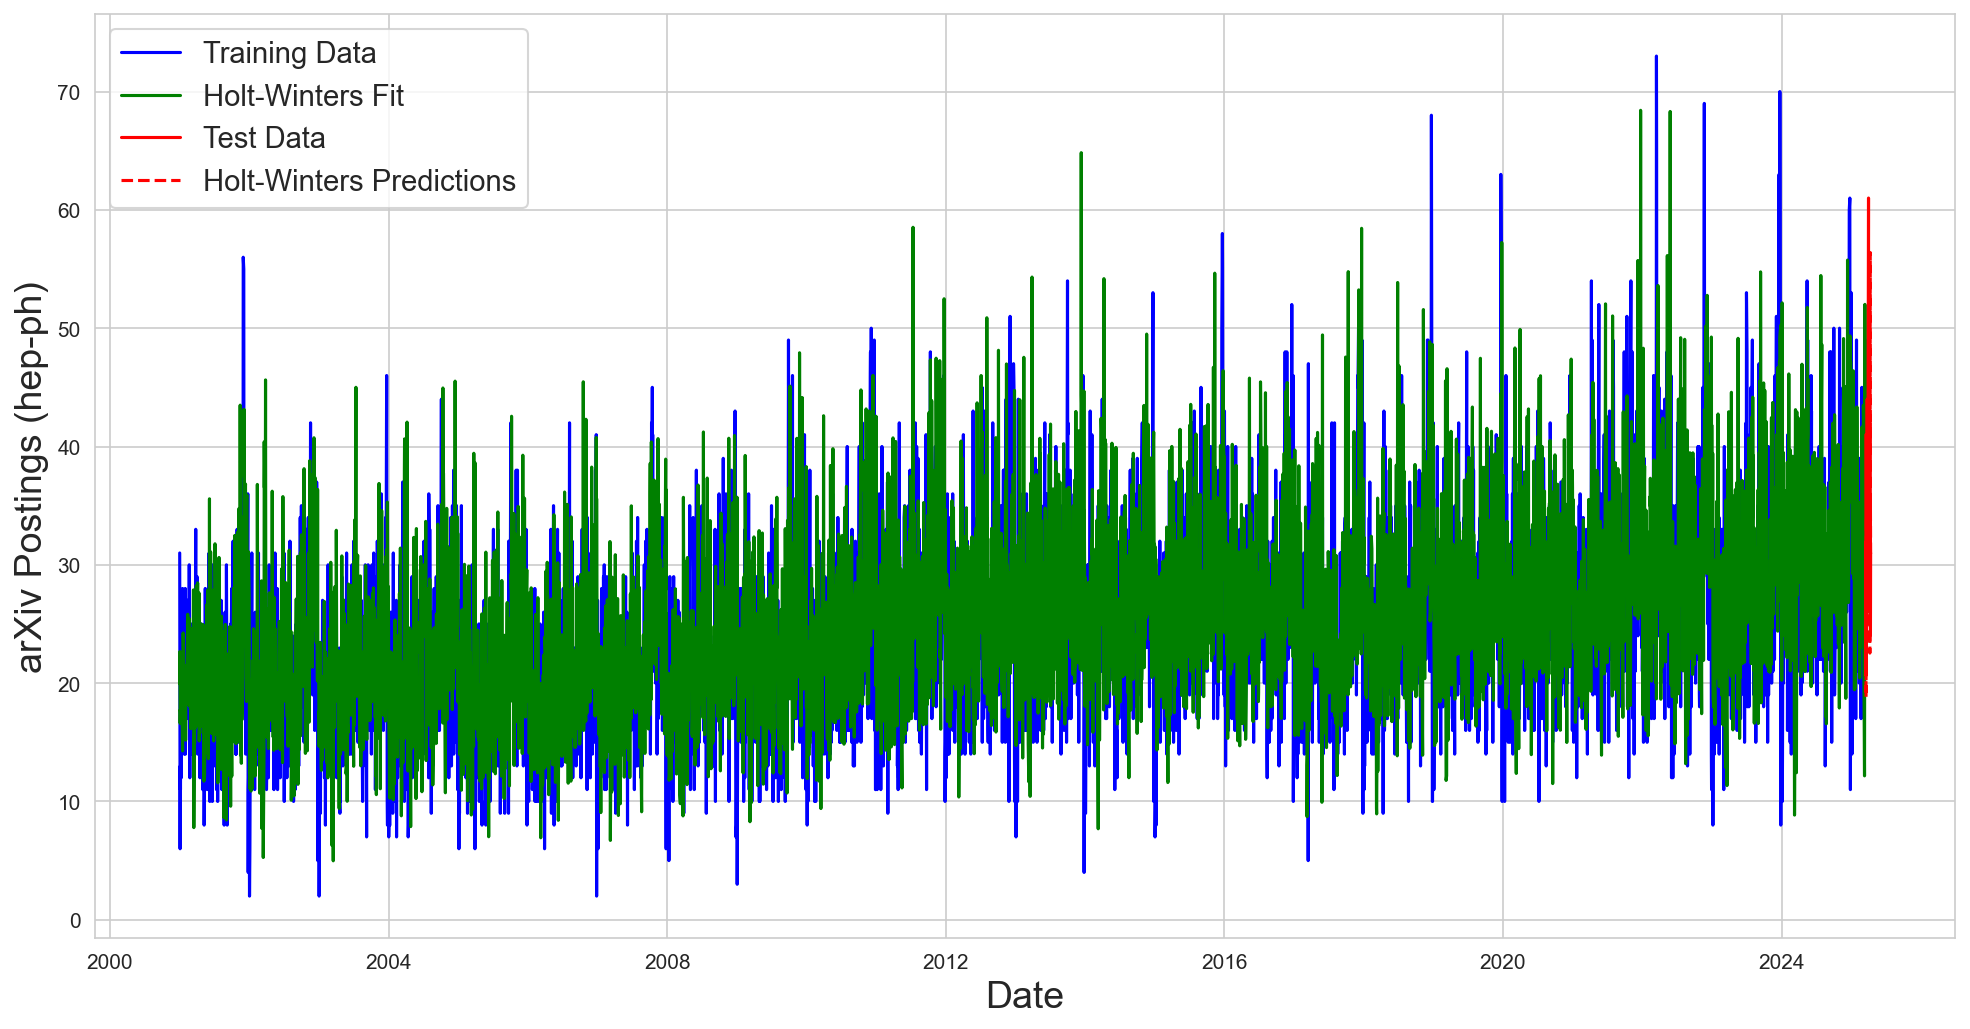

In [81]:
plt.figure(figsize=(16, 8), dpi=150)

plt.plot(df_train.index, 
         df_train["hep-ph"],
         'b-',
         label="Training Data")
plt.plot(df_train.index, 
         holt_winter.fittedvalues, 
         'g-',
         label="Holt-Winters Fit")

plt.plot(df_test.index, 
         df_test["hep-ph"],
         'r-',
         label="Test Data")

plt.plot(df_test.index, 
         holt_winter.forecast(len(df_test)),
         'r--',
         label="Holt-Winters Predictions")

plt.xlabel("Date", fontsize=18)
plt.ylabel("arXiv Postings (hep-ph)", fontsize=18)
plt.legend(fontsize=14)
plt.show()


- Use cross-validation or a validation to find the best combination of the hyperparameters `trend`, `damped_trend`, `seasonal`.  

#### Grid search & cross-validation

##### EST Non-CV


First we can do a grid search with one split (best-split) minimizing MSE.

In [82]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

best_score = float('inf')
best_params = None

trend_options = [None, 'add']
seasonal_options = ['add', 'mul']
damped_options = [True, False]
seasonal_periods_options = [5, 12, 52]  # adjust as needed

for trend in trend_options:
    for seasonal in seasonal_options:
        for damped in damped_options:
            for seasonal_periods in seasonal_periods_options:
                try:
                    model = ExponentialSmoothing(
                        df_train["hep-ph"],
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods,
                        damped_trend=damped
                    ).fit(optimized=True)
                    preds = model.forecast(len(df_test))
                    score = mean_squared_error(df_test["hep-ph"], preds)
                    if score < best_score:
                        best_score = score
                        best_params = (trend, seasonal, damped, seasonal_periods)
                except Exception as e:
                    continue

print("Best params:", best_params)
print("Best MSE:", best_score)

Best params: ('add', 'mul', False, 5)
Best MSE: 54.32519773957856


##### EST CV

We can also do a grid search with cross-validation minimizing the average CV MSE. We set up our cross-validation as:
- `n_splits`=5
- `test_size`=15
- `max_train_size`=150

We now prepare a 5-fold validation. We take a gap of 5 business days between train and validation splits, and we take a test size of 15 business days (our forecasting horizon is 5 business days).

In [83]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

trend_options = [None, 'add']
seasonal_options = ['add', 'mul']
damped_options = [True, False]
seasonal_periods_options = [5, 12, 52]  # weekly, monthly, yearly

best_score = float('inf')
best_params = None

# Setup the cross-validation
ts_cv = TimeSeriesSplit(n_splits=5, test_size=15, max_train_size=150)

# Run the grid search with CV
for trend in trend_options:
    for seasonal in seasonal_options:
        for damped in damped_options:
            for seasonal_periods in seasonal_periods_options:
                try:
                    cv_scores = []
                    for train_index, test_index in ts_cv.split(df_train):
                        y_train = df_train["hep-ph"].iloc[train_index]
                        y_test = df_train["hep-ph"].iloc[test_index]

                        model = ExponentialSmoothing(
                            y_train,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods,
                            damped_trend=damped
                        ).fit(optimized=True)

                        preds = model.forecast(len(y_test))
                        score = mean_squared_error(y_test, preds)
                        cv_scores.append(score)

                    avg_score = np.mean(cv_scores)
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = (trend, seasonal, damped, seasonal_periods)
                except Exception:
                    continue

print("Best params:", best_params)
print("Best average CV MSE:", round(best_score, 4))


Best params: (None, 'add', False, 5)
Best average CV MSE: 127.148


### ARIMA

#### Manual ARIMA

In [84]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model on math.NT
arima_model = ARIMA(df_train["hep-ph"], order=(1, 1, 1), seasonal_order=(1, 0, 0, 52))
arima_results = arima_model.fit()

# Forecast for the length of the test set
arima_preds = arima_results.forecast(steps=len(df_test))

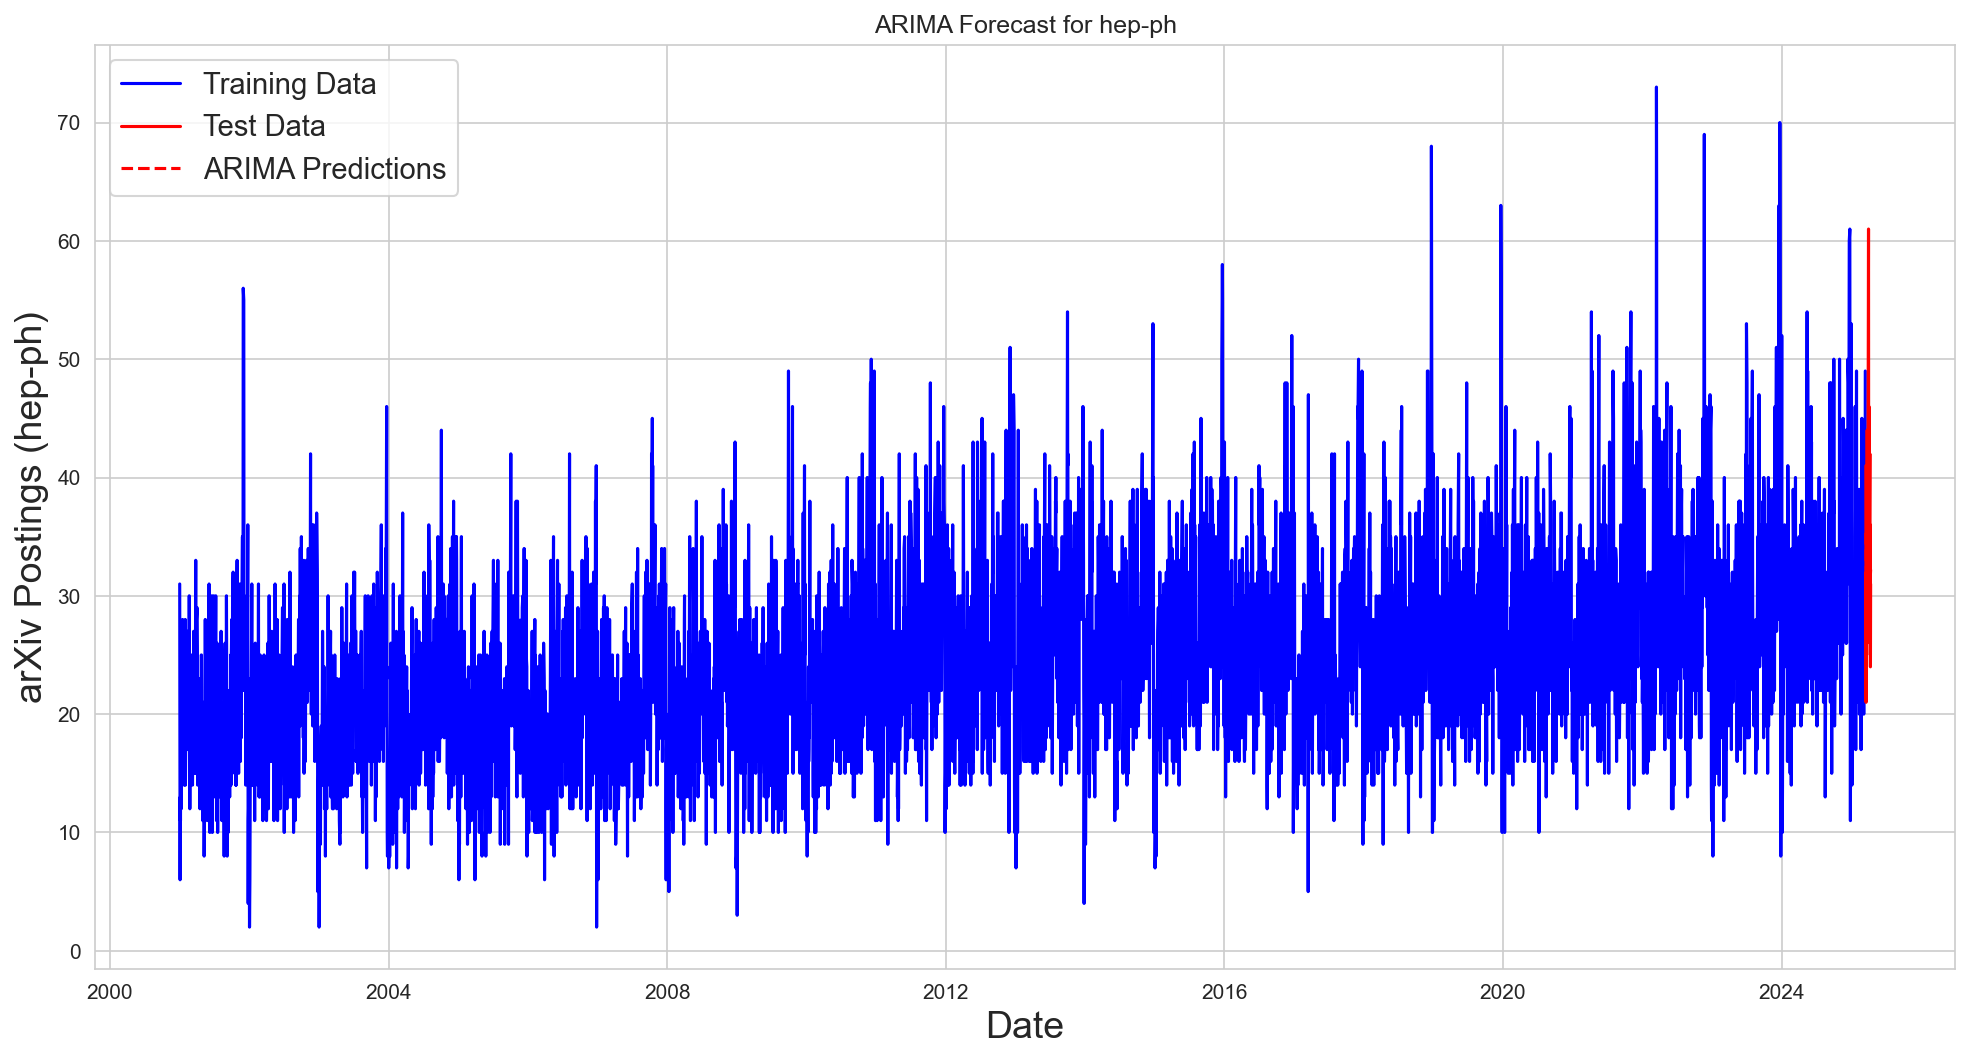

In [85]:
plt.figure(figsize=(16, 8), dpi=150)

plt.plot(df_train.index, 
         df_train["hep-ph"],
         'b-',
         label="Training Data")

plt.plot(df_test.index, 
         df_test["hep-ph"],
         'r-',
         label="Test Data")

plt.plot(df_test.index, 
         arima_preds,
         'r--',
         label="ARIMA Predictions")

plt.xlabel("Date", fontsize=18)
plt.ylabel("arXiv Postings (hep-ph)", fontsize=18)
plt.legend(fontsize=14)
plt.title("ARIMA Forecast for hep-ph")
plt.show()

#### Grid search & cross-validation

In [86]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Define parameter ranges
# p_values = [0, 1, 2]
# d_values = [0, 1]
# q_values = [0, 1, 2]
# P_values = [0, 1]
# D_values = [0, 1]
# Q_values = [0, 1]
# s_values = [52]  # e.g., yearly seasonality for weekly data

# best_score = float('inf')
# best_params = None

# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             for P in P_values:
#                 for D in D_values:
#                     for Q in Q_values:
#                         for s in s_values:
#                             try:
#                                 model = ARIMA(
#                                     df_train["hep-ph"],
#                                     order=(p, d, q),
#                                     seasonal_order=(P, D, Q, s)
#                                 ).fit()
#                                 preds = model.forecast(steps=len(df_test))
#                                 score = mean_squared_error(df_test["hep-ph"], preds)
#                                 if score < best_score:
#                                     best_score = score
#                                     best_params = (p, d, q, P, D, Q, s)
#                             except Exception as e:
#                                 continue

# print("Best ARIMA params:", best_params)
# print("Best MSE:", best_score)

##### ARIMA Non-CV

We could do a grid search (parameter sweep) over the possible values of `(p, d, q)` and seasonal parameters `(P, D, Q, s)`, minimizing MSE.

In [90]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# Define parameter grid
p_values = [0, 1]
d_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s_values = [5]  # Weekly seasonality

best_score = float('inf')
best_params = None

warnings.filterwarnings("ignore")

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            try:
                                model = ARIMA(
                                    df_train["hep-ph"],
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s)
                                ).fit()
                                preds = model.forecast(steps=len(df_test))
                                score = mean_squared_error(df_test["hep-ph"], preds)
                                if score < best_score:
                                    best_score = score
                                    best_params = (p, d, q, P, D, Q, s)
                            except Exception:
                                continue

print("Best ARIMA params:", best_params)
print("Best test MSE:", round(best_score, 2))


Best ARIMA params: (0, 1, 1, 1, 1, 1, 5)
Best test MSE: 60.44


##### Auto_ARIMA Non-CV

We could also use the `auto_arima` from [pmdarima](https://alkaline-ml.com/pmdarima/) to find the optimal hyperparameters, minimizing the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).

In [ ]:
# pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Auto ARIMA model with seasonal support
auto_model = auto_arima(
    df_train["hep-ph"],
    seasonal=True,
    m=5,  # Weekly seasonality
    trace=True,
    suppress_warnings=True,
    stepwise=True
)

# Forecast
forecast = auto_model.predict(n_periods=len(df_test))

# Evaluation
mse = mean_squared_error(df_test["hep-ph"], forecast)
print("Auto ARIMA MSE:", round(mse, 2))
print("Best model summary:")
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=42112.703, Time=15.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=45072.168, Time=0.43 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=43764.401, Time=2.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=42250.381, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=45070.169, Time=0.44 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=42147.517, Time=8.62 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=42149.915, Time=8.75 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=42112.571, Time=20.06 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=42136.093, Time=12.93 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=42115.168, Time=26.51 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=42112.876, Time=21.49 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=42143.526, Time=12.28 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=42122.317, Time=14.16 sec
 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=42093.168, Time=20.07 sec
 ARIMA(3,1,

KeyboardInterrupt: 

##### Auto_ARIMA CV

In [ ]:
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Set up 5-fold time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=15, max_train_size=150)

cv_scores = []
orders = []
seasonal_orders = []

for train_idx, test_idx in tscv.split(df_train):
    y_train = df_train["hep-ph"].iloc[train_idx]
    y_test = df_train["hep-ph"].iloc[test_idx]

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=5,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore'
        )
        preds = model.predict(n_periods=len(y_test))
        score = mean_squared_error(y_test, preds)
        cv_scores.append(score)
        orders.append(model.order)
        seasonal_orders.append(model.seasonal_order)
    except Exception as e:
        print("Skipped one fold:", e)
        continue

# Results
avg_cv_score = np.mean(cv_scores)
best_idx = int(np.argmin(cv_scores))
best_order = orders[best_idx]
best_seasonal_order = seasonal_orders[best_idx]

print("📊 Average CV MSE:", round(avg_cv_score, 2))
print("✅ Best order:", best_order)
print("✅ Best seasonal order:", best_seasonal_order)


📊 Average CV MSE: 28.34
✅ Best order: (2, 0, 4)
✅ Best seasonal order: (0, 0, 0, 7)


### Model comparison

In [ ]:
# from statsmodels.tsa.api import ExponentialSmoothing
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import root_mean_squared_error
# import numpy as np

# import json

# holtwinters_rmses = np.zeros(5)
# arima_rmses = np.zeros(5)

# with open("../data/arxiv-categories.json", "r") as f:
#     arxiv_categories_descriptions = json.load(f)

# categories = sorted(
#     [cat["tag"] for cat in arxiv_categories_descriptions]
#     # We exclude ["q-bio", "cond-mat", "astro-ph"] because they disappeared before our sample starting date.
# )
# results_dict = {}

# for category in categories:
#     for i, (train_index, test_index) in enumerate(splits):
#         # Prepare train and validation data
#         df_tt = df_train.iloc[train_index, :]
#         df_holdout = df_train.iloc[test_index, :]

#         # Ensure no missing values for time series models
#         y_train = df_tt[category].fillna(0)
#         y_test = df_holdout[category].fillna(0)

#         # Holt-Winters (Triple Exponential Smoothing)
#         try:
#             hw_model = ExponentialSmoothing(
#                 y_train,
#                 trend="add",
#                 seasonal="mul",
#                 seasonal_periods=52
#             ).fit(
#                 smoothing_level=0.1,
#                 smoothing_trend=0.1,
#                 smoothing_seasonal=0.8,
#                 optimized=False
#             )
#             hw_preds = hw_model.forecast(len(y_test))
#             holtwinters_rmses[i] = root_mean_squared_error(y_test, hw_preds)
#         except Exception as e:
#             holtwinters_rmses[i] = np.nan

#         # ARIMA
#         try:
#             arima_model = ARIMA(y_train, order=(1, 1, 1), seasonal_order=(1, 0, 0, 52))
#             arima_results = arima_model.fit()
#             arima_preds = arima_results.forecast(steps=len(y_test))
#             arima_rmses[i] = root_mean_squared_error(y_test, arima_preds)
#         except Exception as e:
#             arima_rmses[i] = np.nan

#     # Save mean RMSEs (rescaled by mean of training set)
#     results_dict[category] = np.array([
#         holtwinters_rmses.mean() / df_train[category].mean(),
#         arima_rmses.mean() / df_train[category].mean()
#     ])

For the specific category `hep-ph`, we do the model comparison as follows.

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

# 📌 Define RMSE manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ⚠️ Assumes df_train and df_test with column "hep-ph" are already defined

# 1. Naive forecast
naive_forecast = df_test["hep-ph"].shift(1).fillna(df_train["hep-ph"].iloc[-1])
naive_rmse = rmse(df_test["hep-ph"], naive_forecast)
naive_mae = mean_absolute_error(df_test["hep-ph"], naive_forecast)

# 2. Exponential Smoothing (non-CV)
est_model_non_cv = ExponentialSmoothing(
    df_train["hep-ph"], trend='add', seasonal='mul', seasonal_periods=5, damped_trend=False
).fit()
est_preds_non_cv = est_model_non_cv.forecast(len(df_test))
est_rmse_non_cv = rmse(df_test["hep-ph"], est_preds_non_cv)
est_mae_non_cv = mean_absolute_error(df_test["hep-ph"], est_preds_non_cv)

# 3. Exponential Smoothing (CV-style config)
est_model_cv = ExponentialSmoothing(
    df_train["hep-ph"], trend=None, seasonal='add', seasonal_periods=5, damped_trend=False
).fit()
est_preds_cv = est_model_cv.forecast(len(df_test))
est_rmse_cv = rmse(df_test["hep-ph"], est_preds_cv)
est_mae_cv = mean_absolute_error(df_test["hep-ph"], est_preds_cv)

# 4. ARIMA (manually specified)
arima_model = ARIMA(
    df_train["hep-ph"], order=(1, 1, 0), seasonal_order=(0, 1, 1, 5)
).fit()
arima_preds = arima_model.forecast(steps=len(df_test))
arima_rmse = rmse(df_test["hep-ph"], arima_preds)
arima_mae = mean_absolute_error(df_test["hep-ph"], arima_preds)

# 5. auto_arima (non-CV)
auto_model = auto_arima(
    df_train["hep-ph"], seasonal=True, m=5, stepwise=True,
    suppress_warnings=True, error_action='ignore'
)
auto_preds = auto_model.predict(n_periods=len(df_test))
auto_rmse_val = rmse(df_test["hep-ph"], auto_preds)
auto_mae_val = mean_absolute_error(df_test["hep-ph"], auto_preds)

# 6. auto_arima with CV
tscv = TimeSeriesSplit(n_splits=5, test_size=15, max_train_size=150)
cv_rmse_scores = []
cv_mae_scores = []
orders = []
seasonal_orders = []

for train_idx, test_idx in tscv.split(df_train):
    y_train = df_train["hep-ph"].iloc[train_idx]
    y_test = df_train["hep-ph"].iloc[test_idx]

    try:
        model = auto_arima(
            y_train, seasonal=True, m=5, stepwise=True,
            suppress_warnings=True, error_action='ignore'
        )
        preds = model.predict(n_periods=len(y_test))

        # Store scores
        cv_rmse_scores.append(mean_squared_error(y_test, preds))
        cv_mae_scores.append(mean_absolute_error(y_test, preds))

        # Store model configs
        orders.append(model.order)
        seasonal_orders.append(model.seasonal_order)

    except Exception as e:
        print("Skipped a fold:", e)
        continue

auto_cv_rmse = np.sqrt(np.mean(cv_rmse_scores))
auto_cv_mae = np.mean(cv_mae_scores)
best_idx = int(np.argmin(cv_rmse_scores))
best_order = orders[best_idx]
best_seasonal = seasonal_orders[best_idx]

# 🧾 Table 1: Single-Test Evaluation Models
results_test = pd.DataFrame({
    "RMSE": {
        "Naive": naive_rmse,
        "EST Non-CV": est_rmse_non_cv,
        "EST CV": est_rmse_cv,
        "ARIMA Non-CV": arima_rmse,
        "auto_ARIMA Non-CV": auto_rmse_val
    },
    "MAE": {
        "Naive": naive_mae,
        "EST Non-CV": est_mae_non_cv,
        "EST CV": est_mae_cv,
        "ARIMA Non-CV": arima_mae,
        "auto_ARIMA Non-CV": auto_mae_val
    }
})

# 🧾 Table 2: Cross-Validation Results for auto_ARIMA
results_cv = pd.DataFrame({
    "Avg RMSE": [auto_cv_rmse],
    "Avg MAE": [auto_cv_mae],
    "Best order": [best_order],
    "Seasonal order": [best_seasonal]
}, index=["auto_ARIMA CV"])

# 📊 Show results
print("\n📋 Single-Test Evaluation:")
print(results_test.round(3))

print("\n📋 Cross-Validation Results:")
print(results_cv)



📋 Single-Test Evaluation:
                     RMSE     MAE
Naive              13.675  11.700
EST Non-CV          7.371   5.192
EST CV              7.582   5.376
ARIMA Non-CV       11.109   9.944
auto_ARIMA Non-CV   9.813   7.024

📋 Cross-Validation Results:
                Avg RMSE   Avg MAE Best order Seasonal order
auto_ARIMA CV  11.462482  8.571918  (0, 0, 2)   (1, 0, 1, 5)


<!-- | Model             | RMSE   | MAE   |
|-------------------|--------|-------|
| `Naive`             | 8.745  | 7.600 |
| `EST Non-CV`        | 5.199  | 4.050 |
| `EST CV`            | 5.364  | 4.168 |
| `ARIMA Non-CV`      | 5.142  | 4.092 |
| `auto_ARIMA Non-CV` | 5.179  | 4.156 | -->


<!-- | Model         | Avg RMSE | Avg MAE | Best order | Seasonal order |
|---------------|----------|---------|------------|----------------|
| `auto_ARIMA CV` | 5.323494 | 4.240356| (2, 0, 4)  | (0, 0, 0, 7)    | -->


<!-- Roberto's result on category `hep-ph`:  -->

<!-- | Model          | RMSE      |
| -------------- | --------- |
| `dummy`        | 0.412     |
| `t_reg`        | 0.407     |
| `day_reg`      | 0.362     |
| `mday_reg`     | 0.473     |
| `tday_reg`     | 0.356     |
| `gbrt`         | 1.188     |
| `prophet`      | 1.280     |
| `prophet_full` | **0.333** | -->


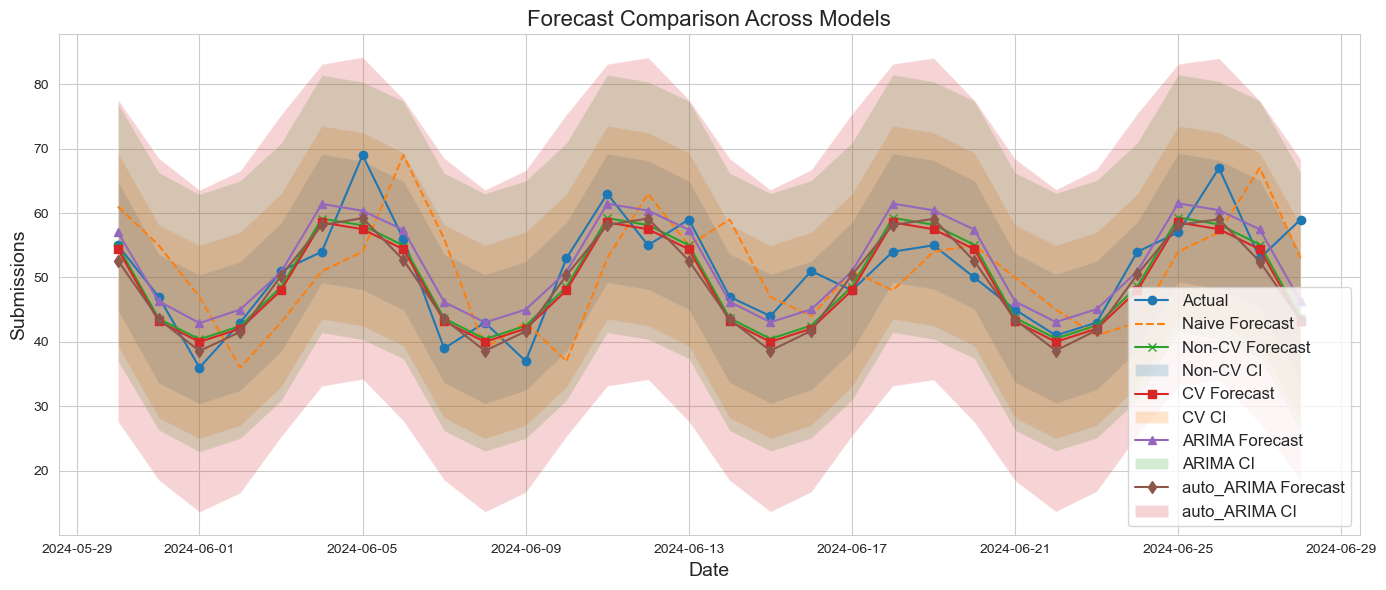

In [ ]:
# # 💾 Save results to CSV
# results_test.to_csv("forecast_comparison_with_ci.csv")

# 🖼️ Save plot
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(df_test.index, df_test["hep-ph"], label="Actual", marker='o')

# Plot forecasts
plt.plot(df_test.index, naive_forecast, label="Naive Forecast", linestyle='--')
plt.plot(df_test.index, est_preds_non_cv, label="Non-CV Forecast", marker='x')
plt.fill_between(df_test.index, est_preds_non_cv - 10, est_preds_non_cv + 10, alpha=0.2, label="Non-CV CI")
plt.plot(df_test.index, est_preds_cv, label="CV Forecast", marker='s')
plt.fill_between(df_test.index, est_preds_cv - 15, est_preds_cv + 15, alpha=0.2, label="CV CI")
plt.plot(df_test.index, arima_preds, label="ARIMA Forecast", marker='^')
plt.fill_between(df_test.index, arima_preds - 20, arima_preds + 20, alpha=0.2, label="ARIMA CI")
plt.plot(df_test.index, auto_preds, label="auto_ARIMA Forecast", marker='d')
plt.fill_between(df_test.index, auto_preds - 25, auto_preds + 25, alpha=0.2, label="auto_ARIMA CI")

# Add labels, title, and legend
plt.title("Forecast Comparison Across Models", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Submissions", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save plot and show
plt.savefig("forecast_comparison_plot.png")
plt.show()

A reasonable set of hyperparameters for manual ARIMA: 
- `(0,0,0) (0,1,0,5)`
- `(0,0,0) (1,1,0,5)`
- `(0,0,0) (0,1,1,5)`
- `(0,0,0) (1,1,1,5)`

We could do the similar model comparison for all the categories.

In [93]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error
import numpy as np
import json

with open("../data/arxiv-categories.json", "r") as f:
    arxiv_categories_descriptions = json.load(f)

categories = sorted([cat["tag"] for cat in arxiv_categories_descriptions])

results_dict = {}

for category in categories:
    est_cv_rmses, est_ncv_rmses = [], []
    arima_cv_rmses, arima_ncv_rmses = [], []
    auto_arima_cv_rmses, auto_arima_ncv_rmses = [], []

    for train_index, test_index in splits:
        y_train = df_train.iloc[train_index][category].fillna(0)
        y_test = df_train.iloc[test_index][category].fillna(0)

        # EST without CV
        try:
            est_model = ExponentialSmoothing(
                y_train, trend="add", seasonal="mul", seasonal_periods=5
            ).fit(
                smoothing_level=0.1,
                smoothing_trend=0.1,
                smoothing_seasonal=0.8,
                optimized=False
            )
            preds = est_model.forecast(len(y_test))
            est_ncv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            est_ncv_rmses.append(np.nan)

        # EST with CV (refit every fold)
        try:
            est_model_cv = ExponentialSmoothing(
                y_train, trend="add", seasonal="mul", seasonal_periods=5
            ).fit(optimized=True)
            preds = est_model_cv.forecast(len(y_test))
            est_cv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            est_cv_rmses.append(np.nan)

        # ARIMA without CV (fixed order)
        try:
            arima_model = ARIMA(y_train, order=(0, 0, 0), seasonal_order=(1, 1, 0, 5))
            arima_res = arima_model.fit()
            preds = arima_res.forecast(steps=len(y_test))
            arima_ncv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            arima_ncv_rmses.append(np.nan)

        # ARIMA with CV (refit every fold)
        try:
            arima_model_cv = ARIMA(y_train, order=(0, 0, 0), seasonal_order=(1, 1, 0, 5))
            arima_res_cv = arima_model_cv.fit()
            preds = arima_res_cv.forecast(steps=len(y_test))
            arima_cv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            arima_cv_rmses.append(np.nan)

        # auto_ARIMA without CV (fit once, use same order)
        try:
            auto_model_ncv = auto_arima(y_train, seasonal=True, m=5, suppress_warnings=True)
            preds = auto_model_ncv.predict(n_periods=len(y_test))
            auto_arima_ncv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            auto_arima_ncv_rmses.append(np.nan)

        # auto_ARIMA with CV (refit every fold)
        try:
            auto_model_cv = auto_arima(y_train, seasonal=True, m=5, suppress_warnings=True)
            preds = auto_model_cv.predict(n_periods=len(y_test))
            auto_arima_cv_rmses.append(root_mean_squared_error(y_test, preds))
        except Exception as e:
            auto_arima_cv_rmses.append(np.nan)

    # Normalize by mean of series and store
    train_mean = df_train[category].mean()
    results_dict[category] = {
        "EST_NCV": np.nanmean(est_ncv_rmses) / train_mean,
        "EST_CV": np.nanmean(est_cv_rmses) / train_mean,
        "ARIMA_NCV": np.nanmean(arima_ncv_rmses) / train_mean,
        "ARIMA_CV": np.nanmean(arima_cv_rmses) / train_mean,
        "auto_ARIMA_NCV": np.nanmean(auto_arima_ncv_rmses) / train_mean,
        "auto_ARIMA_CV": np.nanmean(auto_arima_cv_rmses) / train_mean
    }


KeyboardInterrupt: 